In [1]:
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import pyflux as pf
import os
import statsmodels.api as sm
from pandas.plotting import register_matplotlib_converters
%matplotlib inline

In [2]:
data_dir = 'data/'

In [3]:
sns.set(rc={'figure.figsize': (12,8)})

In [4]:
date_parser = lambda x: pd.datetime.strptime(x, "%d/%m/%Y 12:00:00 a.m.")
df = pd.read_csv(os.path.join(data_dir, 'datasetRofex2.csv'),
                 parse_dates=['Fecha'],
                 index_col='Fecha',
                 date_parser=date_parser)
futuros = pd.read_csv(os.path.join(data_dir, 'Futuros.csv'),
                 parse_dates=['Fecha'],
                 index_col='Fecha',
                 date_parser=date_parser)
futuros = futuros.append(df.loc['2019-08-29'])

In [5]:
df['retornos'] = df['Cierre'].pct_change();
retornos = df['retornos'].dropna()

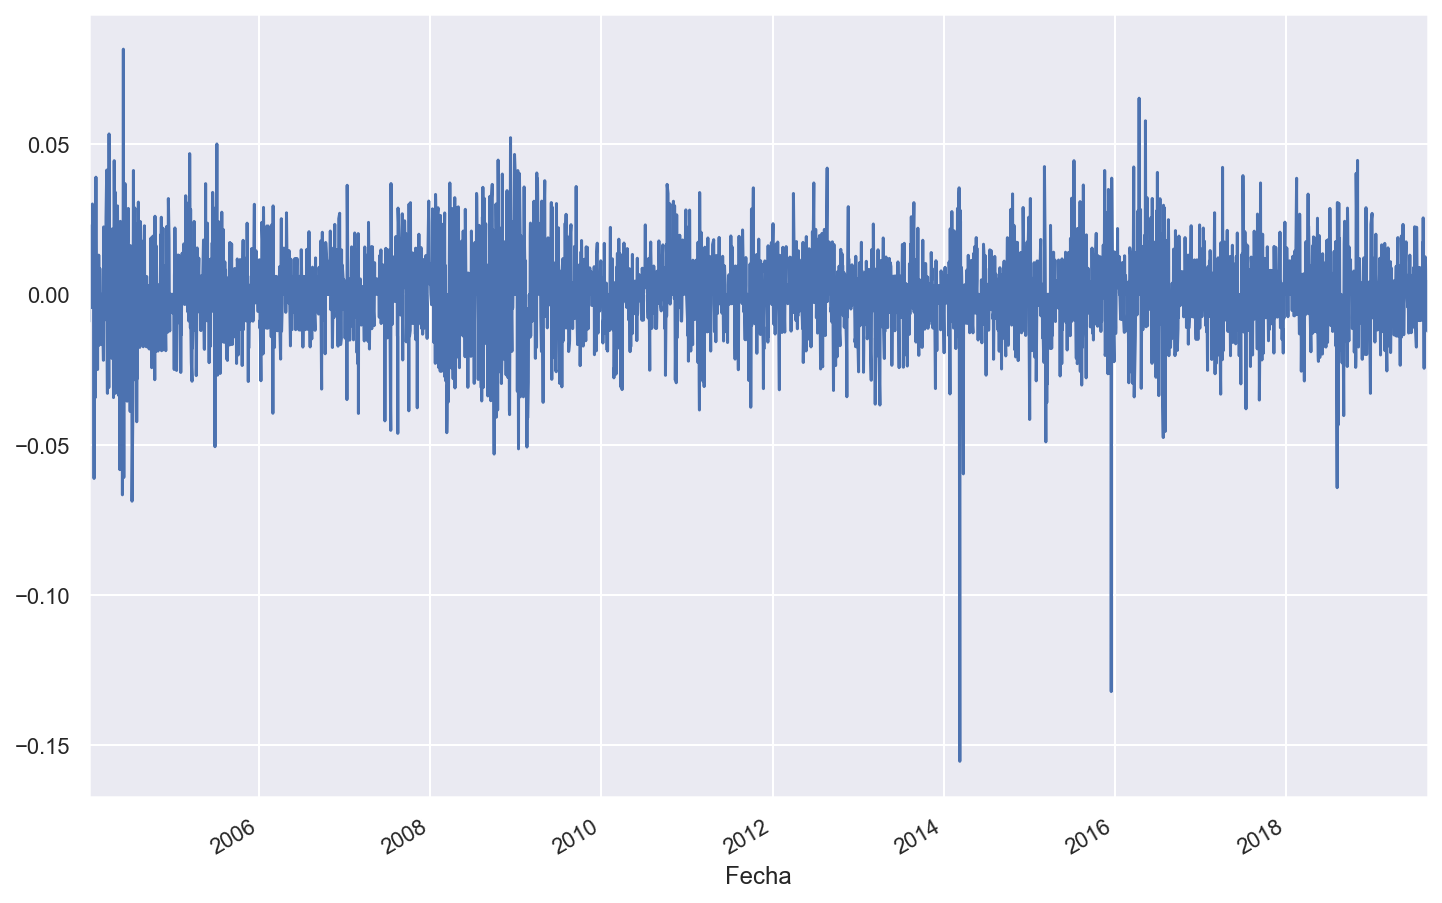

In [6]:
retornos.plot();

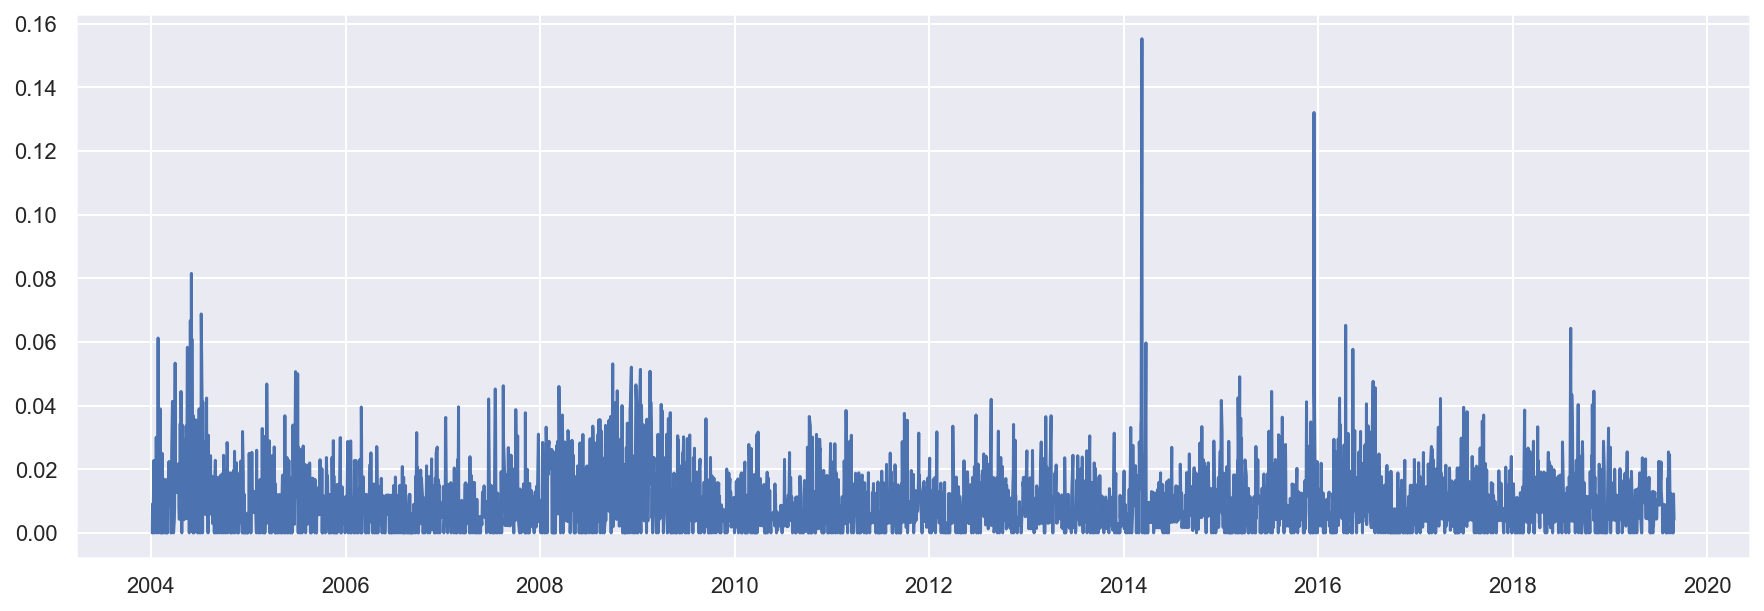

In [7]:
plt.figure(figsize=(15,5))
plt.plot(retornos.index, np.abs(retornos.values));

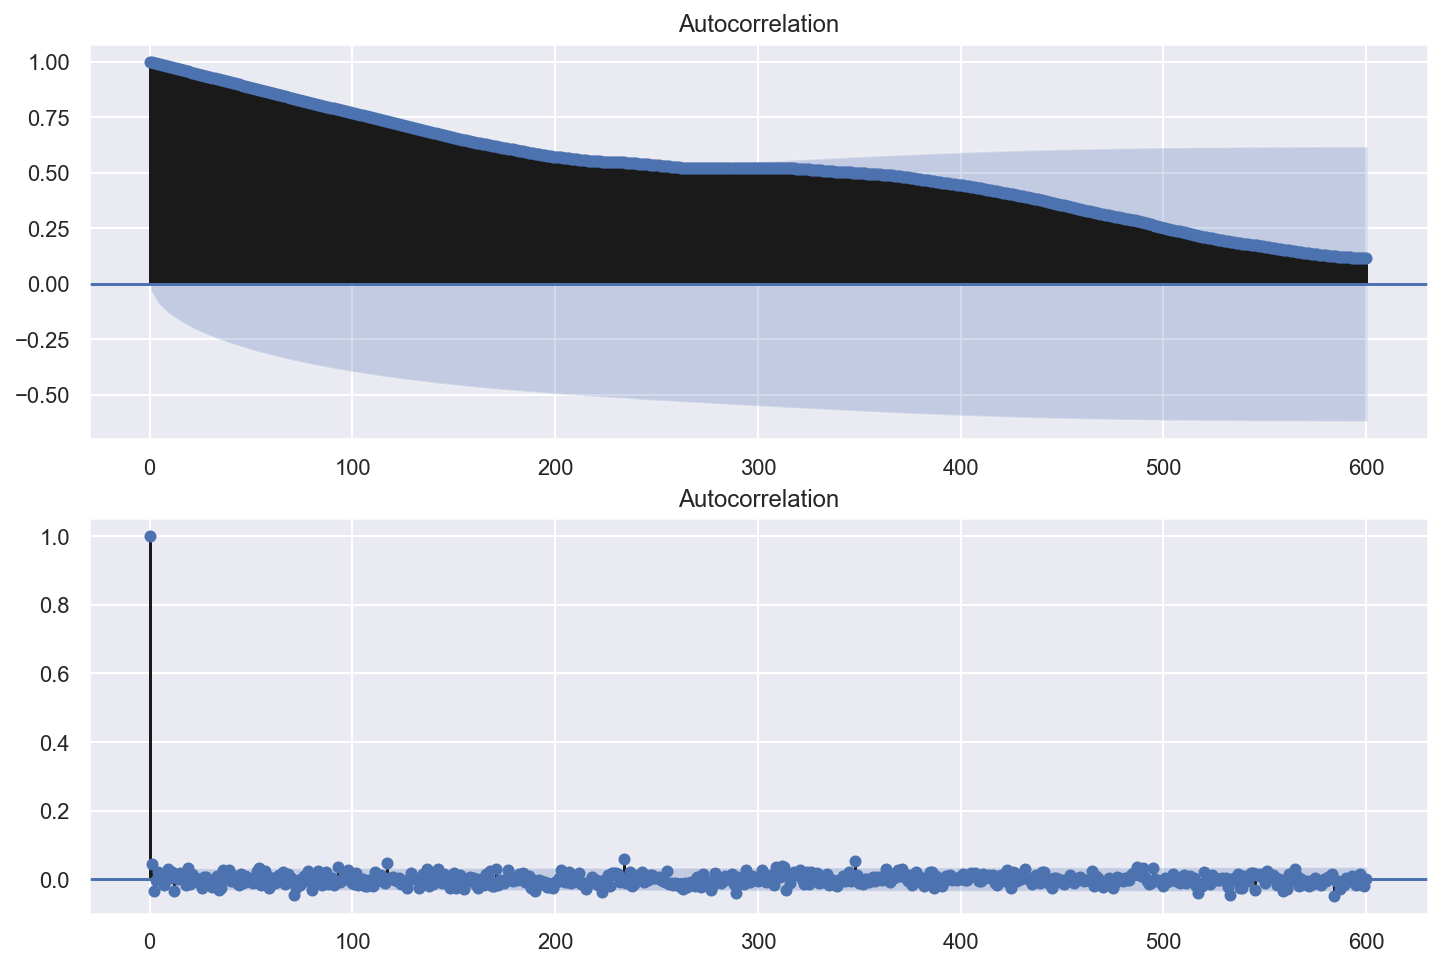

In [8]:
fig, (ax1, ax2) = plt.subplots(2)
sm.graphics.tsa.plot_acf(df['Cierre'], ax=ax1,lags=600)
sm.graphics.tsa.plot_acf(retornos, ax=ax2,lags=600);

In [9]:
#Parámetros
#ARIMA
p = 1
q = 1
#GARCH
r = 1
s = 1
#Número de predicciones a futuro
n = 122

In [10]:
model_arima = sm.tsa.statespace.SARIMAX(retornos.values,order=(p,0,q), seasonal=False)

In [11]:
fit = model_arima.fit()

In [12]:
mean_prediction = fit.forecast(n)

In [13]:
residuos = fit.resid

In [14]:
model = pf.GARCH(residuos,r,s)
x = model.fit()
x.summary()

GARCH(1,1)                                                                                                
======================================================= ==================================================
Dependent Variable: Series                              Method: MLE                                       
Start Date: 1                                           Log Likelihood: 11166.526                         
End Date: 3852                                          AIC: -22325.0521                                  
Number of observations: 3852                            BIC: -22300.0267                                  
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Vol Constant                             0.0                                                              
q(1)                                 

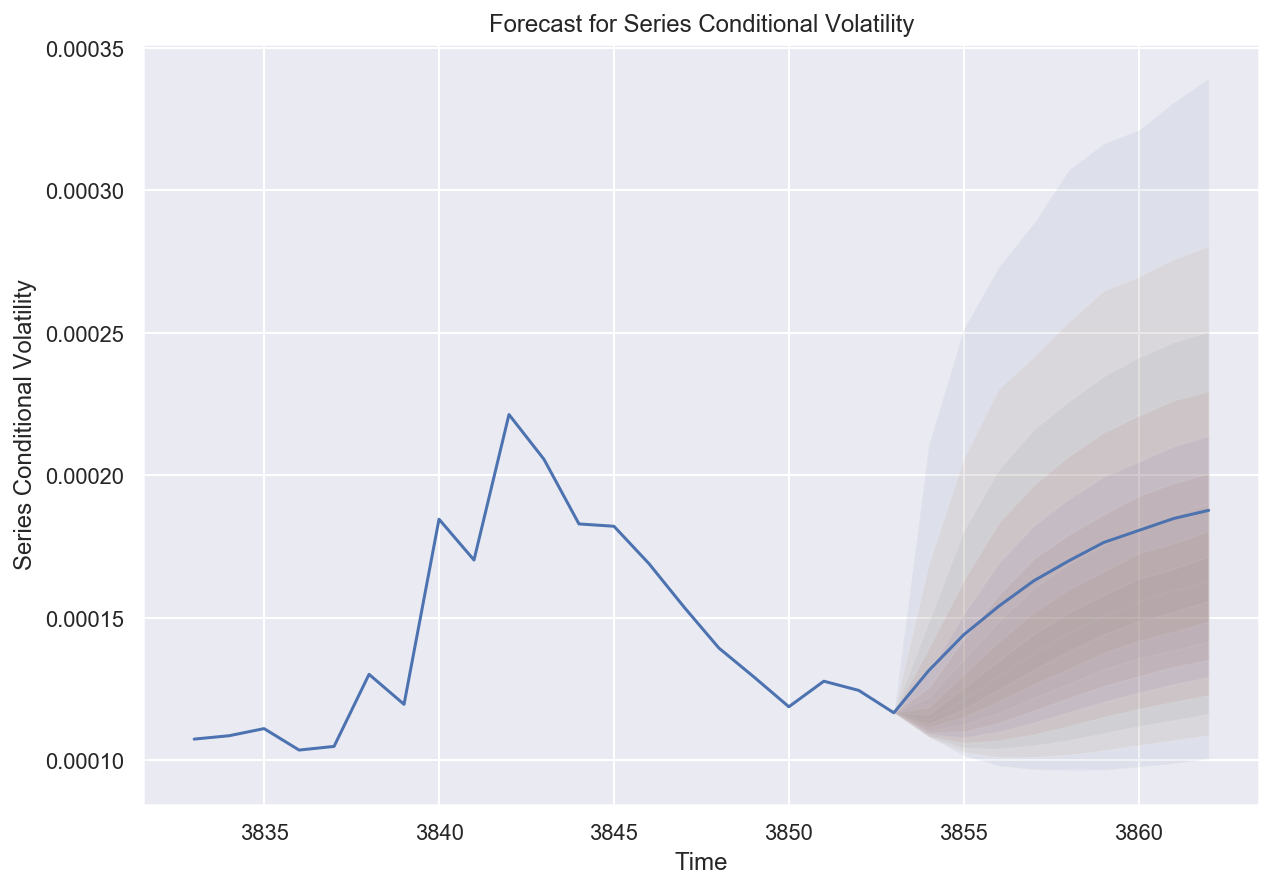

In [15]:
model.plot_predict(h=10)

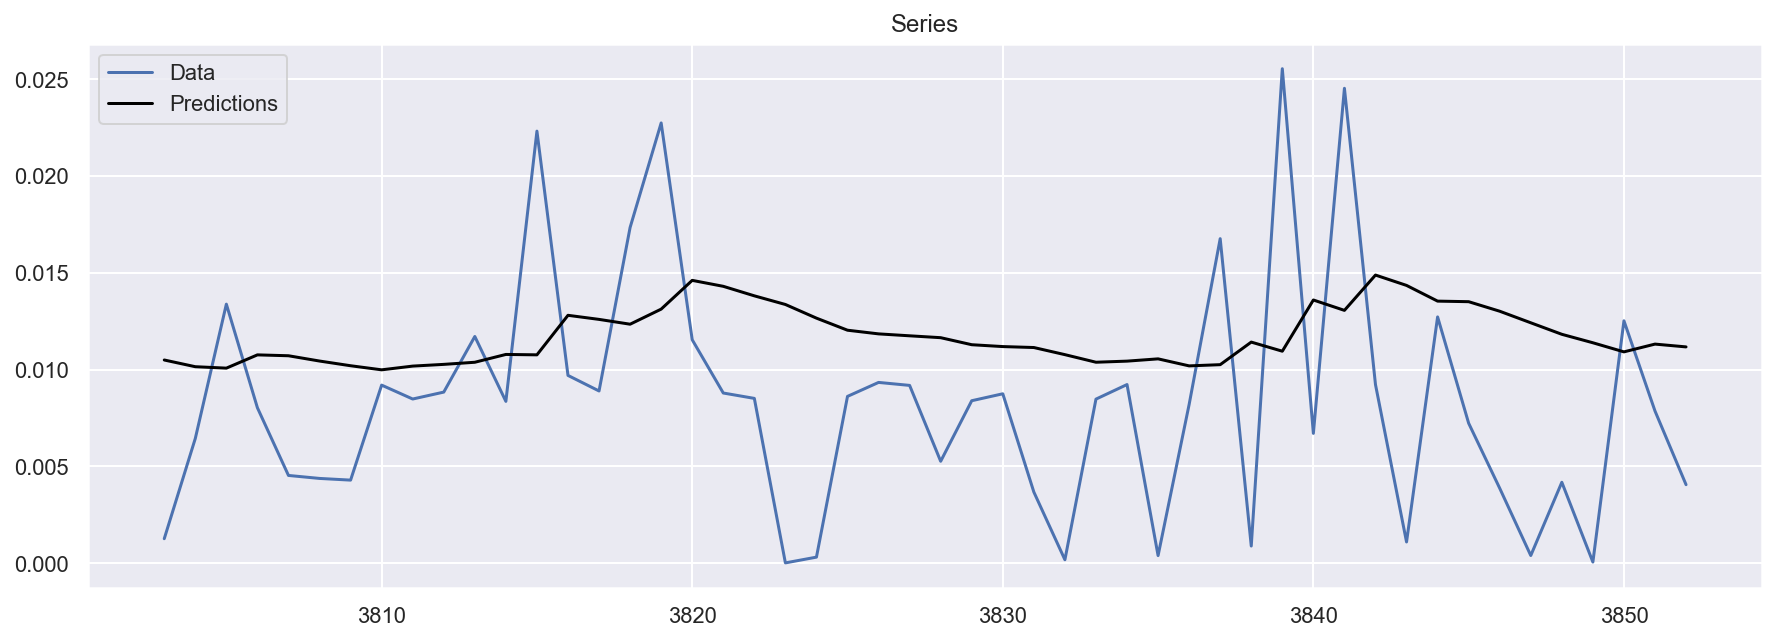

In [16]:
model.plot_predict_is(h=50,figsize=(15,5))

In [17]:
variance_prediction = model.predict(n)

In [18]:
def predict(mu, var, normal_samples):
    return (mu + normal_samples * np.sqrt(var))

In [19]:
normal_samples = np.random.normal(0,1,n)

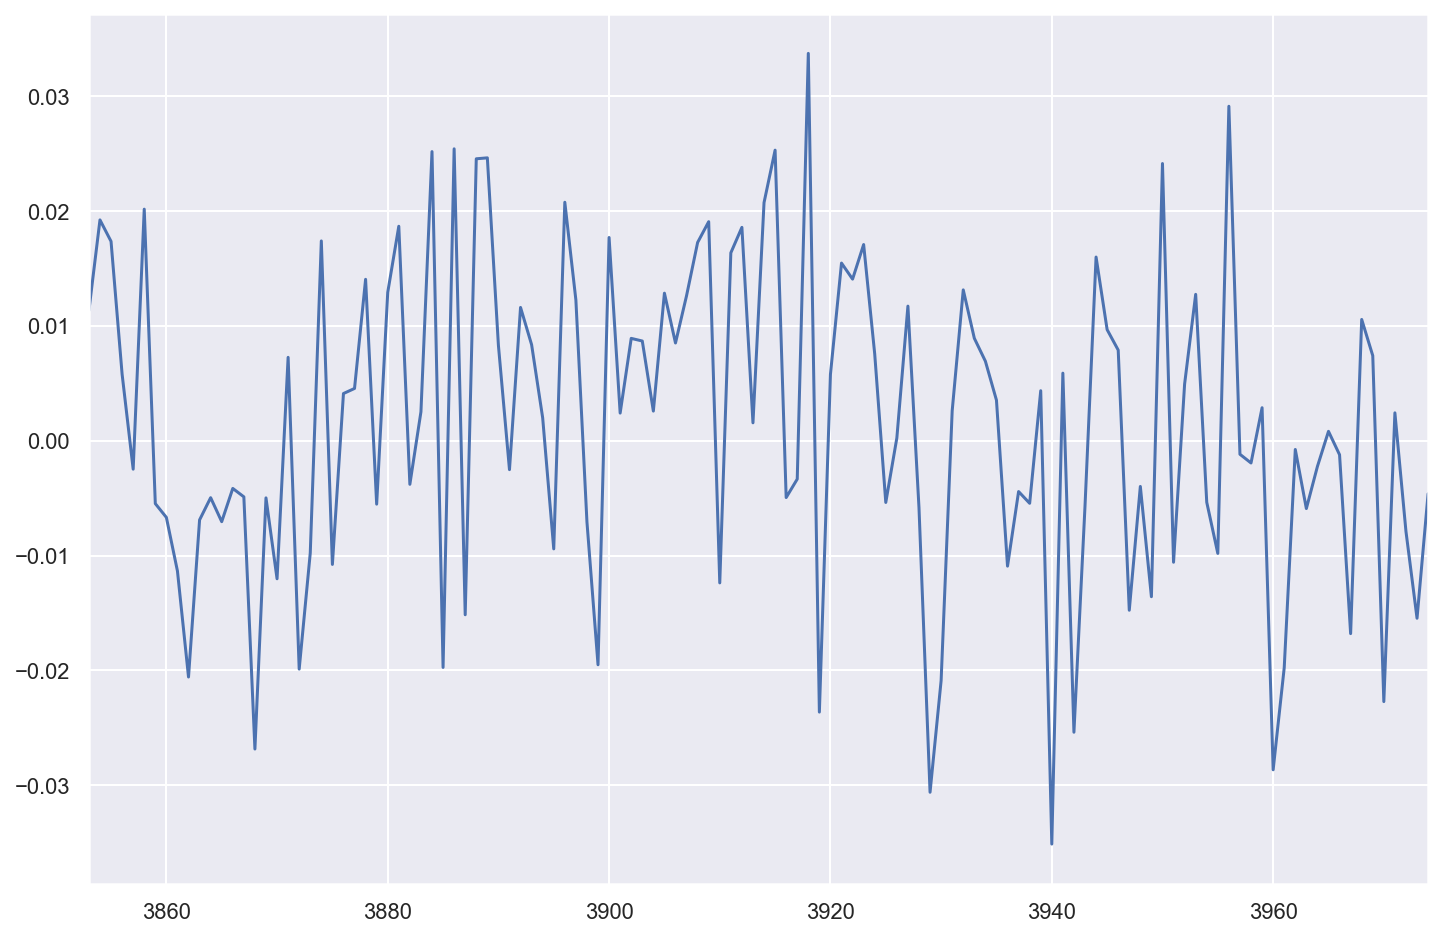

In [20]:
#Predicción de los retornos
predicted_returns = predict(mean_prediction, variance_prediction['Series'], normal_samples)
predicted_returns.plot();

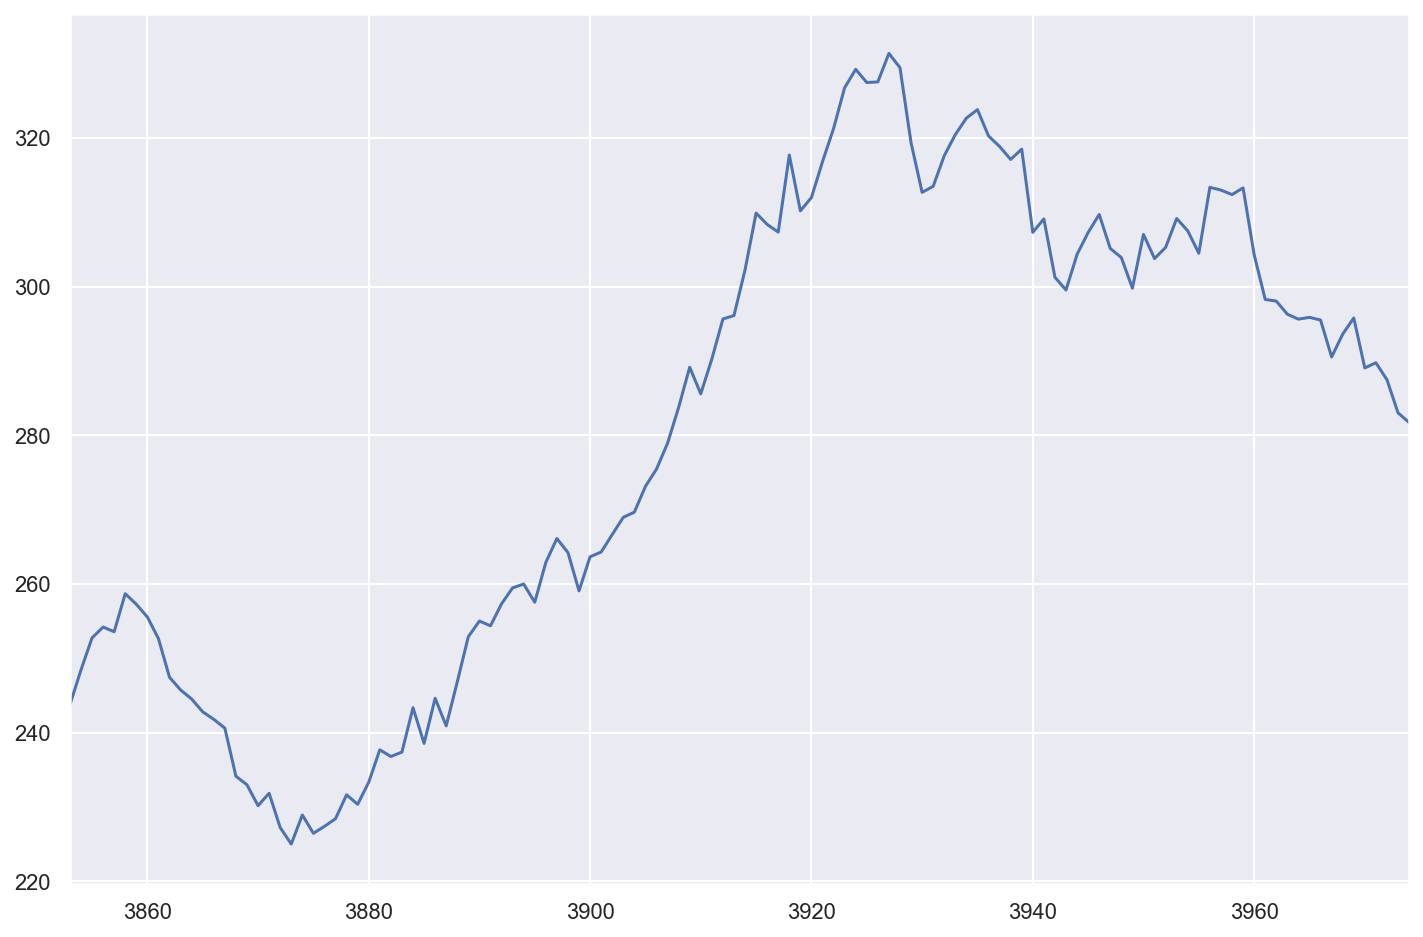

In [21]:
#Predicción del precio de cierre
predicted_close = (1 + predicted_returns).cumprod() * df['Cierre'][-1]
predicted_close.plot();

In [22]:
futuros.sort_index(inplace=True)
daily_returns_futuros = futuros['Cierre'].pct_change().dropna()
daily_returns_futuros = daily_returns_futuros.dropna()

In [23]:
#Error en los retornos ARIMA-GARCH
diff = (daily_returns_futuros.reset_index()['Cierre'].values - predicted_returns[:13].values)
diff_abs = np.abs(diff)
np.sum(diff_abs)/13

0.01487898213239631

In [24]:
#Error en los retornos si se predice con el último valor
daily_returns_futuros.abs().sum()/13

0.007413082079339508

In [25]:
#Error en el precio de cierre ARIMA-GARCH
diff_close = (futuros.reset_index()['Cierre'][1:].values - predicted_close[:13].values)
diff_close_abs = np.abs(diff_close)
np.sum(diff_close_abs)/13

10.78959673206346

In [26]:
#Error en el precio de cierre si se predice con el último valor
diff_close_last_value = (futuros.reset_index()['Cierre'][1:].values - df['Cierre'][-1])
diff_close_last_value_abs = np.abs(diff_close_last_value)
np.sum(diff_close_last_value_abs)/13

1.8461538461538463

Al aplicar ARIMA sobre la serie de retornos el resultado es prácticamente cero, lo cual es esperable ya que la idea es que el método capture la [media condicional](https://en.wikipedia.org/wiki/Conditional_expectation) del proceso, y se ve claramente que ésta es (aproximadamente) cero en el gráfico. Luego, aplicando GARCH y calculando la predicción final obtenemos esencialmente un sampleo a una distribución normal con media cero y desviación estándar entre $0.01$ y $0.02$. 

En estas condiciones, la predicción a la que llegamos no es muy diferente a tomar el último valor de precio de cierre. De hecho, si comparamos el error absoluto medio (MAE) de ambas predicciones para las dos semanas posteriores a nuestros datos, la predicción que toma el último valor es más precisa que ARIMA-GARCH. Sin embargo, si quisiéramos predecir los retornos de (por ejemplo) los próximos seis meses, ARIMA-GARCH posiblemente de un mejor resultado, porque captura mejor la naturaleza casi azarosa de la serie.